In [2]:
import json
import pandas as pd
import gzip
import sys
sys.path.append('../src')
from utils import *
import numpy as np
from itertools import combinations, product, permutations

In [3]:

meta = getDF('../../project/meta_Sports_and_Outdoors.json', save=False)
df = pd.read_csv('../../project/Sports_and_Outdoors_5_2016_2018.csv')

In [4]:
meta['price'] = meta['price'].str.replace('$', '')
meta['price'] = meta['price'].replace('nan', 0).replace('', 0)
meta['price'] = meta['price'].apply(pd.to_numeric, errors='coerce').fillna(0)

meta['also_buy'] = meta['also_buy'].fillna('[]').apply(lambda x: len(x))
meta['also_view'] = meta['also_view'].fillna('[]').apply(lambda x: len(x))

meta = meta.drop(['tech2', 'tech1', 'fit', 'date', 'details', 'imageURL', 'imageURLHighRes', 'rank', 'similar_item', 'description', 'feature'], axis=1)

C:\Users\aurav\AppData\Local\Temp\ipykernel_18276\3759937403.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  meta['price'] = meta['price'].str.replace('$', '')


# group definition

g1<average order price, main category order,order frequency>

In [5]:
# count number of order for each reviewer
df = df.join(meta.set_index('asin'), on='asin')
df['nb_order'] = df.groupby('reviewerID')['reviewerID'].transform('count')
# make average price for each reviewer
df['avg_price'] = df.groupby('reviewerID')['price'].transform('mean')
df.head()

,overall,reviewTime,reviewerID,asin,reviewText,unixReviewTime,category,title,also_buy,brand,also_view,main_cat,price,nb_order,avg_price
0,5.0,2016-12-27,ASAE9FBGAJQAH,0899332757,Arrived on time. Nice Atlas - Easy to read.,1482796800,"[Sports & Outdoors, Outdoor Recreation, Campin...",Delorme New York State Atlas &amp; Gazetteer,78.0,Garmin,38.0,Office Products,19.95,11,21.160909
1,3.0,2016-12-12,A1TAW91SQSU2AH,0899332757,More of a road map than a useful topographical...,1481500800,"[Sports & Outdoors, Outdoor Recreation, Campin...",Delorme New York State Atlas &amp; Gazetteer,78.0,Garmin,38.0,Office Products,19.95,4,9.585000
2,5.0,2016-08-13,A1SVGO4GMEOXQ0,0899332757,Comprehensive atlas. Very happy with how much ...,1471046400,"[Sports & Outdoors, Outdoor Recreation, Campin...",Delorme New York State Atlas &amp; Gazetteer,78.0,Garmin,38.0,Office Products,19.95,4,9.065000
3,5.0,2016-08-02,A36QT6N7N0GF3O,0899332757,Delorme has always made the best book maps in ...,1470096000,"[Sports & Outdoors, Outdoor Recreation, Campin...",Delorme New York State Atlas &amp; Gazetteer,78.0,Garmin,38.0,Office Products,19.95,7,10.232857
4,5.0,2016-07-14,AJGZDX7KC5TVQ,0899332757,worked great on the trip around ny,1468454400,"[Sports & Outdoors, Outdoor Recreation, Campin...",Delorme New York State Atlas &amp; Gazetteer,78.0,Garmin,38.0,Office Products,19.95,5,39.394000


In [6]:
# for each reviewer, count number of order by main_cat in a df2 who have just the reviewerID and the main_cat
df2 = df[['reviewerID', 'main_cat']]
#group by reviewerID and main_cat and count the number of order
df2 = df2.groupby(['reviewerID', 'main_cat']).size().reset_index(name='nb_order_main_cat')
df2 = df2.drop_duplicates()
df2 = df2.loc[df2.groupby('reviewerID')['nb_order_main_cat'].idxmax()]

df2 = df2.rename(columns={'main_cat':'main_cat2'})
df = df.join(df2.set_index('reviewerID'), on='reviewerID')
df1 = df[['reviewerID', 'nb_order', 'avg_price', 'main_cat2']] 
df1 = df1.rename(columns={'main_cat2':'main_cat'})

# drop '' and '[]' in main_cat
df1 = df1[df1.main_cat != '']

df1.head()

,reviewerID,nb_order,avg_price,main_cat
0,ASAE9FBGAJQAH,11,21.160909,Sports & Outdoors
1,A1TAW91SQSU2AH,4,9.585000,Sports & Outdoors
2,A1SVGO4GMEOXQ0,4,9.065000,Sports & Outdoors
3,A36QT6N7N0GF3O,7,10.232857,Sports & Outdoors
4,AJGZDX7KC5TVQ,5,39.394000,Tools & Home Improvement


<Axes: >

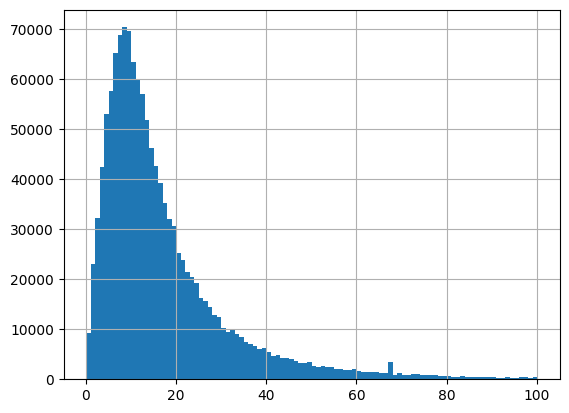

In [7]:
df1 = df1[df1['avg_price'] < 100]
df1 = df1[df1['avg_price'] > 0]
df1['avg_price'].hist(bins=100)

<Axes: >

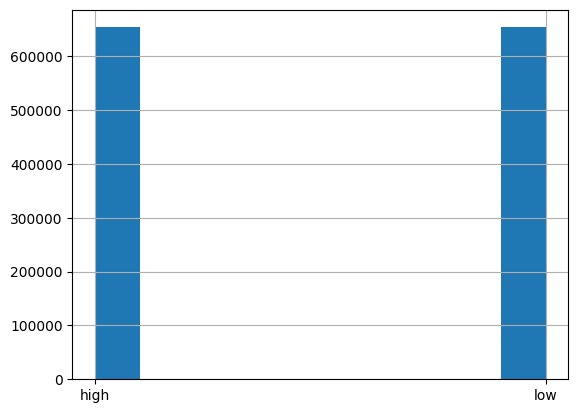

In [8]:
df1['spender'] = np.where(df1['avg_price'] > df1['avg_price'].median(), 'high', 'low')
df1['spender'].hist()

<Axes: >

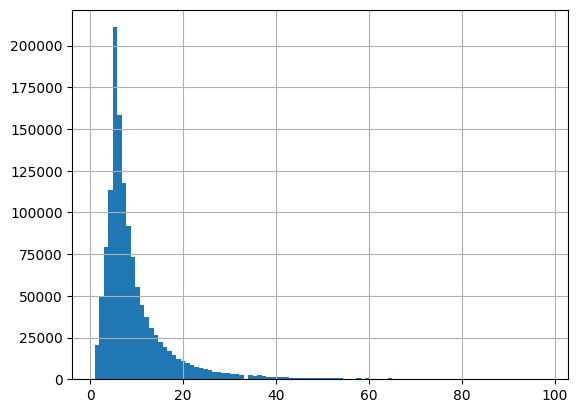

In [9]:
df1 = df1[df1['nb_order'] < 100]
df1['nb_order'].hist(bins=100)

<Axes: >

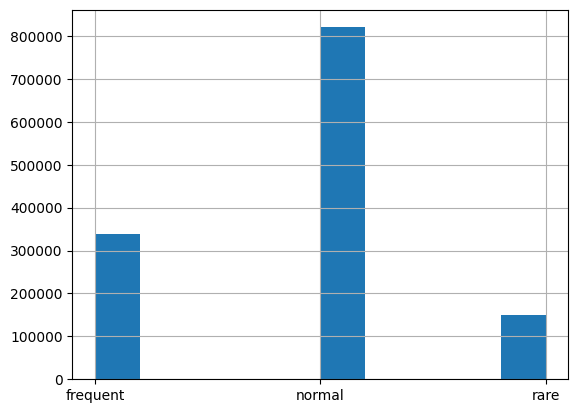

In [10]:
df1['order'] = np.where(df1['nb_order'] > 10, 'frequent', np.where(df1['nb_order'] > 3, 'normal', 'rare'))
df1['order'].hist()

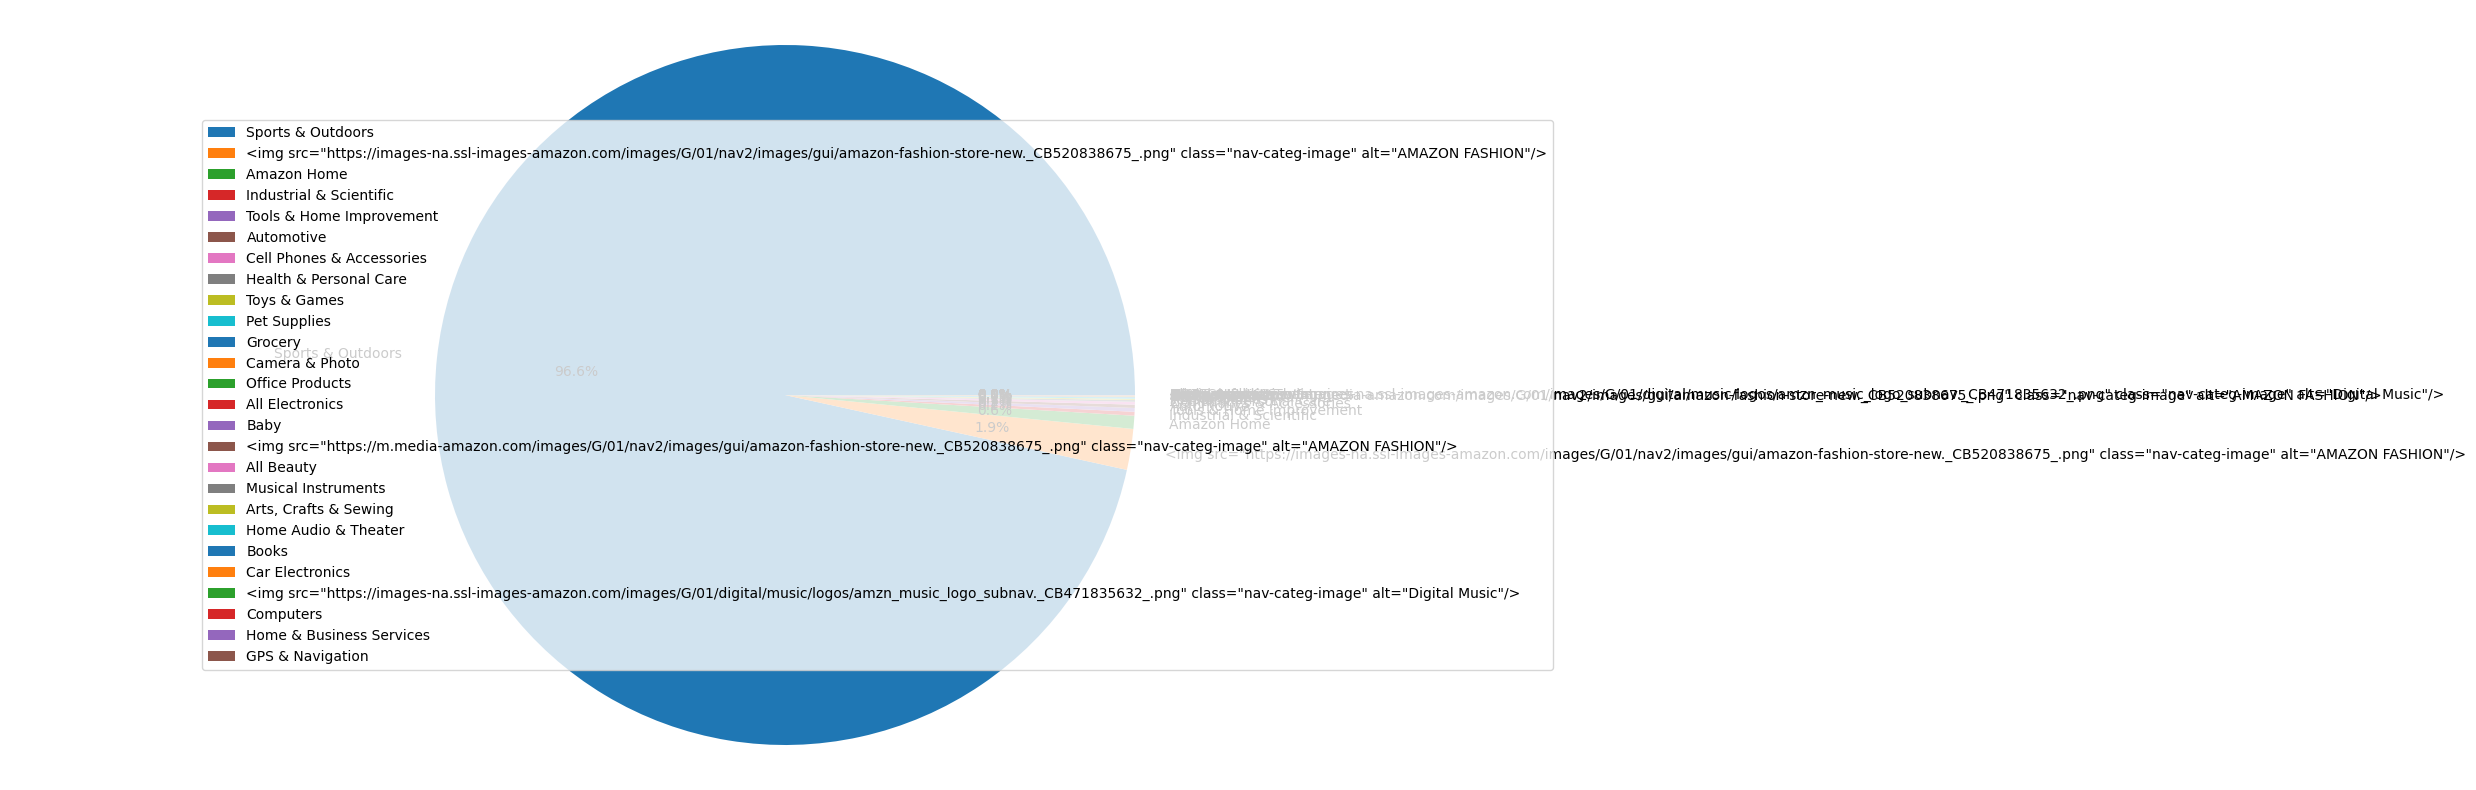

In [11]:
import matplotlib.pyplot as plt
dfcat = df1.groupby('main_cat').size().reset_index(name='count')
dfcat["percentage"] = dfcat["count"]/dfcat["count"].sum()*100
dfcat = dfcat.sort_values(by=['percentage'], ascending=False)
#plot bar
plt.figure(figsize=(20, 10))
plt.pie(dfcat['percentage'], labels=dfcat['main_cat'], autopct='%1.1f%%')
plt.axis('equal')

# Positionnement de la légende
plt.legend(dfcat['main_cat'], loc="best")  # "best" ajustera automatiquement la position

plt.show()

In [12]:
df1['main_cat'] = df1['main_cat'].astype(str)
df1 = df1[~df1['main_cat'].str.startswith('<')]
df1['main_cat'].value_counts()

df2 = df[['reviewerID', 'overall']]
df2 = df2.groupby('reviewerID')['overall'].mean().reset_index()
df2 = df2.rename(columns={'overall':'avg_rating'})
df1 = df1.join(df2.set_index('reviewerID'), on='reviewerID')

In [13]:
#remove column 'group'
df1.head()

,reviewerID,nb_order,avg_price,main_cat,spender,order,avg_rating
0,ASAE9FBGAJQAH,11,21.160909,Sports & Outdoors,high,frequent,4.272727
1,A1TAW91SQSU2AH,4,9.585000,Sports & Outdoors,low,normal,4.250000
2,A1SVGO4GMEOXQ0,4,9.065000,Sports & Outdoors,low,normal,4.500000
3,A36QT6N7N0GF3O,7,10.232857,Sports & Outdoors,low,normal,4.857143
4,AJGZDX7KC5TVQ,5,39.394000,Tools & Home Improvement,high,normal,5.000000


In [14]:
# make a list with all different groups
main_cat_list = df1['main_cat'].unique().tolist()
spender_list = df1['spender'].unique().tolist()
order_list = df1['order'].unique().tolist()

In [15]:
# remove column group
df1['order'].unique().tolist()

['frequent', 'normal', 'rare']

In [16]:
# compute the coverage for each group, a group is list
def coverage(df, groups):
    """
    Calculate the coverage for a list of groups

    Args:
        df (dataframe): dataframe with the data
        groups (list): list of groups, each group is a dictionary with the keys 'order', 'spender', 'main_cat

    Returns:
        float: coverage
    """

    cover = 0
    for group in groups:
        customers = df.query('spender == @group["spender"]' if 'spender' in group.keys() else 'spender == spender') \
            .query('order == @group["order"]' if 'order' in group.keys() else 'order == order') \
            .query('main_cat == @group["main_cat"]' if 'main_cat' in group.keys() else 'main_cat == main_cat').index
        cover += len(customers)
    return cover / len(df.index)
    

coverage(df1, [{'order': 'rare', 'spender': 'low', 'main_cat': 'Sports & Outdoors'}, {'order': 'normal', 'spender': 'low', 'main_cat': 'Sports & Outdoors'}])

0.3769143259927283

In [17]:
def rename_list(list, name):
    for k in range(len(list)):
        list[k] = (name, list[k])
    return list

def combi_size(list1, list2, list3, size):
    combinations_list = []
    a = combinations([list1, list2, list3], size)
    for ele in a:
        l = product(*ele[0:size])
        for e in l:
            dic = {}
            for i in e:
                dic.update({i[0]: i[1]})
            combinations_list.append(dic)
    return combinations_list

def combi(list1, list2, list3):
    # genere toutes les combinaisons possibles de 3 listes de taille 1, 2 et 3
    combinations_list = []
    for size in range(1, 4):
        combinations_list += combi_size(list1, list2, list3, size)
    return combinations_list

In [18]:
def diversity(df, groups):
    """
    Calculate the diversity of a set of groups, that measures how distinct groups in group-set groups are from each other

    Args:
        df (dataframe): dataframe with the data
        groups (list): list of groups, each group is a dictionary with the keys 'order', 'spender', 'main_cat

    Returns:
        float: diversity
    """
    div = 1
    for group1, group2 in combinations(groups, 2):
        customers1 = df.query('spender == @group1["spender"]' if 'spender' in group1.keys() else 'spender == spender') \
            .query('order == @group1["order"]' if 'order' in group1.keys() else 'order == order') \
            .query('main_cat == @group1["main_cat"]' if 'main_cat' in group1.keys() else 'main_cat == main_cat').index
        customers2 = df.query('spender == @group2["spender"]' if 'spender' in group2.keys() else 'spender == spender') \
            .query('order == @group2["order"]' if 'order' in group2.keys() else 'order == order') \
            .query('main_cat == @group2["main_cat"]' if 'main_cat' in group2.keys() else 'main_cat == main_cat').index
        
        overlapping_propotion = len(customers1.intersection(customers2))
        div += overlapping_propotion
    return 1 / div


diversity(df1, [{'main_cat': 'Toys & Games', 'order': 'normal'}, {'spender': 'low', 'order': 'rare'}])

1.0

In [19]:
def diameter(df, groups):
    """
    Calculate the diameter of a set of groups, that measures how similar customers in the same group are to each other

    Args:
        df (dataframe): dataframe with the data
        groups (list): list of groups, each group is a dictionary with the keys 'order', 'spender', 'main_cat

    Returns:
        float: diameter
    """
    diam = 0
    for group in groups:
        customers = df.query('spender == @group["spender"]' if 'spender' in group.keys() else 'spender == spender') \
            .query('order == @group["order"]' if 'order' in group.keys() else 'order == order') \
            .query('main_cat == @group["main_cat"]' if 'main_cat' in group.keys() else 'main_cat == main_cat').index
        if len(customers) > 1:
            diam += df.loc[customers, 'avg_rating'].max() - df.loc[customers, 'avg_rating'].min()
    return diam / len(groups)

diameter(df1, [{'main_cat': 'Sports & Outdoors'}, {'order': 'frequent', 'spender': 'high'}])

4.0

In [20]:
def construct_plan(df, group):
    """
    Construct a plan from a list of groups

    Args:
        df (dataframe): dataframe with the data
        group (object): list of groups, each group is a dictionary with the keys 'order', 'spender', 'main_cat

    Returns:
        float: diameter
    """
    diam = diameter(df, group)
    div = diversity(df, group)
    cov = coverage(df, group)
    return (group, cov, div, diam)

construct_plan(df1, [{'order': 'frequent', 'spender': 'high'}])

([{'order': 'frequent', 'spender': 'high'}], 0.15184237673109027, 1.0, 4.0)

In [21]:
def alpha_dominated(p1, p2, alpha):
    """
    Check if plan p1 is alpha-dominated by plan p2

    Args:
        p1 (tuple): plan 1
        p2 (tuple): plan 2
        alpha (float): alpha

    Returns:
        bool: True if p1 is alpha-dominated by p2, False otherwise
    """
    return p1[1] * alpha <= p2[1] and p1[2] * alpha <= p2[2] and p1[3] * alpha <= p2[3]

def not_any_alpha_dominated(p1, Pg, alpha):
    """
    Check if plan p1 is alpha-dominated by any plan in Pg

    Args:
        p1 (tuple): plan 1
        Pg (list): list of plans
        alpha (float): alpha

    Returns:
        bool: True if p1 is alpha-dominated by any plan in Pg, False otherwise
    """
    for p2 in Pg:
        if alpha_dominated(p1, p2, alpha):
            return False
    return True

In [22]:
from tqdm import tqdm

def alpha_approximation_MOMRI(k, alpha, df):
    Pa = []
    main_cat = rename_list(df['main_cat'].unique().tolist(), 'main_cat')
    spender = rename_list(df['spender'].unique().tolist(), 'spender')
    order = rename_list(df['order'].unique().tolist(), 'order')
    combination_list = combi(main_cat, spender, order)
 
    for group in tqdm(combination_list):
        Pg = construct_plan(df, [group])
        if not_any_alpha_dominated(Pg, Pa, alpha):
            Pa.append(Pg)
    
    for n in range(2, k + 1):
        for group in combi_size(main_cat, spender, order, n):
            Pg = construct_plan(df, [group])
            if not_any_alpha_dominated(Pg, Pa, alpha):
                Pa.append(Pg)
    return Pa


Pa = alpha_approximation_MOMRI(1, 1.2, df1)
Pa

100%|██████████| 287/287 [05:35<00:00,  1.17s/it]


[([{'main_cat': 'Sports & Outdoors'}], 0.9842947490879149, 1.0, 4.0),
 ([{'main_cat': 'Tools & Home Improvement'}], 0.0017598426823838733, 1.0, 4.0),
 ([{'main_cat': 'Office Products'}], 0.00013723186180751516, 1.0, 4.0),
 ([{'main_cat': 'Amazon Home'}], 0.006155160892662072, 1.0, 4.0),
 ([{'main_cat': 'Industrial & Scientific'}], 0.0018253397073374601, 1.0, 4.0),
 ([{'main_cat': 'Toys & Games'}], 0.0006011691218954215, 1.0, 4.0),
 ([{'main_cat': 'Health & Personal Care'}], 0.0008210519913824628, 1.0, 4.0),
 ([{'main_cat': 'Automotive'}], 0.0015469773512847163, 1.0, 4.0),
 ([{'main_cat': 'Grocery'}], 0.0003758281669955813, 1.0, 4.0),
 ([{'main_cat': 'Cell Phones & Accessories'}],
  0.0013255350288225896,
  1.0,
  4.0),
 ([{'main_cat': 'Camera & Photo'}], 0.00025185165547629204, 1.0, 4.0),
 ([{'main_cat': 'Pet Supplies'}], 0.0005567247121054876, 1.0, 4.0),
 ([{'main_cat': 'Musical Instruments'}], 4.288495681484849e-05, 1.0, 4.0),
 ([{'main_cat': 'Baby'}], 6.861593090375758e-05, 1.0, 4.0

In [23]:
def lattice_based(g, main_cat_l, spender_l, order_l):
    c = []
    category = [('main_cat', main_cat_l), ('spender', spender_l), ('order', order_l)]
    for cat, cat_l in category:
        if not cat in g.keys():
            gn = g.copy()
            for i in range(len(cat_l)):
                gn.update({cat: cat_l[i]})
                c.append(gn.copy())
    return c

lattice_based({'main_cat': 'Sports & Outdoors'}, main_cat_list, spender_list, order_list)

[{'main_cat': 'Sports & Outdoors', 'spender': 'high'},
 {'main_cat': 'Sports & Outdoors', 'spender': 'low'},
 {'main_cat': 'Sports & Outdoors', 'order': 'frequent'},
 {'main_cat': 'Sports & Outdoors', 'order': 'normal'},
 {'main_cat': 'Sports & Outdoors', 'order': 'rare'}]

In [24]:
def shotgun_hill_climbing(G, df):
    main_cat_list = df['main_cat'].unique().tolist()
    spender_list = df['spender'].unique().tolist()
    order_list = df['order'].unique().tolist()

    while True:
        C = []
        for g in G:
            for gp in lattice_based(g, main_cat_list, spender_list, order_list):
                Gp = G.copy()
                Gp = np.delete(Gp, np.where(Gp == g))
                Gp = np.append(Gp, gp)
                C.append((Gp, coverage(df, Gp)))
        if len(C) == 0:
            return G
        C.sort(key=lambda x: x[1], reverse=True)
        if C[0][1] <= coverage(df, G):
            return G
        G = C[0][0].copy()

In [25]:
def make_interval(interval):
    # create a dictionnary between 0 and 1 with the interval
    dic = {}
    for i in range(0, 101):
        if i % (interval * 100) == 0:
            dic.update({i/100: []})
    return dic

def get_interval(dic, value):
    for k in dic.keys():
        if value <= k:
            return k
        
def random_group_set(combinations_list, size):
    return np.random.choice(combinations_list, size, replace=False)

In [26]:
def heuristic_MOMRI(k, alpha, df, interval, n):
    main_cat_list = rename_list(df['main_cat'].unique().tolist(), 'main_cat')
    spender_list = rename_list(df['spender'].unique().tolist(), 'spender')
    order_list = rename_list(df['order'].unique().tolist(), 'order')
    combinations_list = combi(main_cat_list, spender_list, order_list)

    Ph = []
    N = make_interval(interval)
    for _ in tqdm(range(n)):
        Gs = random_group_set(combinations_list, k)
        Gss = shotgun_hill_climbing(Gs, df)
        div = diversity(df, Gss)
        N[get_interval(N, div)].append(Gss)

    for k, v in N.items():
        plans = []
        for g in v:
            plans.append(construct_plan(df, g))
        for plan in plans:
            if not_any_alpha_dominated(plan, plans, alpha):
                Ph.append(plan)
    return Ph

hmomri = heuristic_MOMRI(2, 1.2, df1, 0.1, 100)
hmomri

100%|██████████| 100/100 [14:13<00:00,  8.54s/it]


[(array([{'order': 'rare'},
         {'main_cat': 'Tools & Home Improvement', 'spender': 'high', 'order': 'rare'}],
        dtype=object),
  0.11162174532417518,
  0.002012072434607646,
  4.0),
 (array([{'spender': 'low'},
         {'main_cat': 'Arts, Crafts & Sewing', 'order': 'normal'}],
        dtype=object),
  0.49454308417693243,
  0.09090909090909091,
  2.4),
 (array([{'order': 'rare'}, {'main_cat': 'Grocery', 'order': 'rare'}],
        dtype=object),
  0.11133480597675947,
  0.006756756756756757,
  4.0),
 (array([{'order': 'normal'},
         {'main_cat': 'Pet Supplies', 'spender': 'high', 'order': 'normal'}],
        dtype=object),
  0.626805749079338,
  0.009174311926605505,
  2.6),
 (array([{'main_cat': 'Cell Phones & Accessories'},
         {'main_cat': 'Car Electronics', 'spender': 'low', 'order': 'normal'}],
        dtype=object),
  0.0013255350288225896,
  1.0,
  2.0),
 (array([{'main_cat': 'All Beauty', 'spender': 'high', 'order': 'frequent'},
         {'main_cat': 'Offi

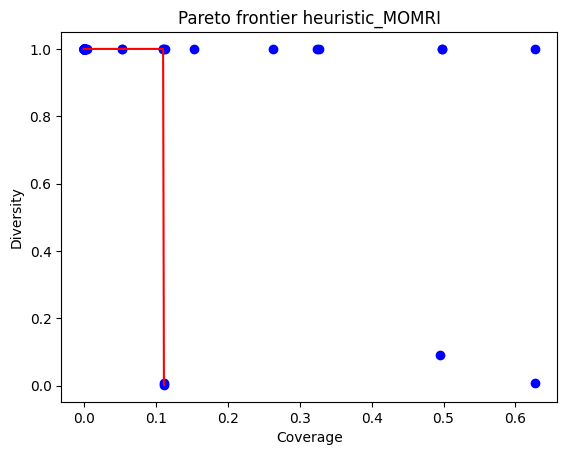

In [36]:
# make a pareto front with the diversity and the coverage
def pareto_frontier(Xs, Ys, maxX=True, maxY=True):
    """
    Method to take a list of X and Y values and return lists of values that lie on the pareto frontier.
    """
    # Sort the list in either ascending or descending order of X
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
    # Start the Pareto frontier with the first value in the sorted list
    p_front = [myList[0]]
    # Loop through the sorted list
    for pair in myList[1:]:
        if maxY:
            if pair[1] >= p_front[-1][1]:
                p_front.append(pair)
        else:
            if pair[1] <= p_front[-1][1]:
                p_front.append(pair)
    # Turn resulting pairs back into a list of Xs and Ys
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY

import matplotlib.pyplot as plt

def plot_pareto_frontier(Xs, Ys, maxX=True, maxY=True, labels=None, name=""):
    """
    Method that takes a list of Xs and Ys and makes a Pareto frontier chart.
    """
    p_frontX, p_frontY = pareto_frontier(Xs, Ys, maxX, maxY)
    plt.scatter(Xs, Ys, color='b')
    plt.plot(p_frontX, p_frontY, color='r')
    plt.ylabel('Diversity')
    plt.xlabel('Coverage')
    plt.title('Pareto frontier ' + name)
    plt.show()

Xs = [plan[1] for plan in hmomri]
Ys = [plan[2] for plan in hmomri]
plot_pareto_frontier(Xs, Ys, maxX=False, maxY=False, name='heuristic_MOMRI')


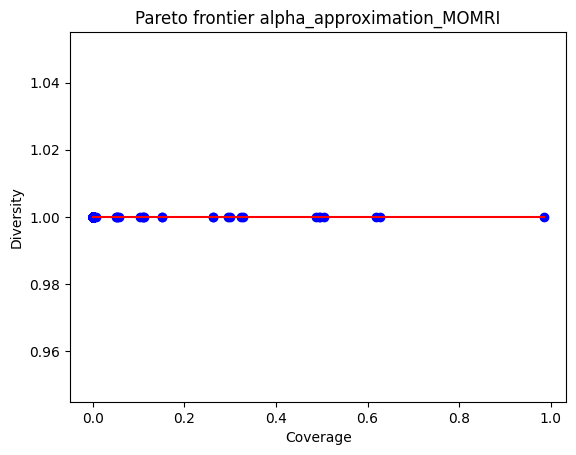

In [37]:

Xs = [plan[1] for plan in Pa]
Ys = [plan[2] for plan in Pa]
plot_pareto_frontier(Xs, Ys, maxX=False, maxY=False, name='alpha_approximation_MOMRI')

In [39]:
# nombre de groupes dans heuristic_MOMRI
len(Pa)

287